In [1]:
#Changing the current directory
%cd "C:\Users\harsh\OneDrive\Documents\Kaggle\Google Taxi Fare forecasting\Google-NY-Taxi-Fare"

C:\Users\harsh\OneDrive\Documents\Kaggle\Google Taxi Fare forecasting\Google-NY-Taxi-Fare


In [2]:
!pip install openpyxl
!pip install geopy
!pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime,date,timedelta,timezone,tzinfo
from dateutil import tz
import pytz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

warnings.filterwarnings('ignore')
Data_test = pd.read_csv("train.csv", nrows=500000)
Data_test.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


### Checking the nulls of all the columns!

In [4]:
Data_test.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [5]:
Data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                500000 non-null  object 
 1   fare_amount        500000 non-null  float64
 2   pickup_datetime    500000 non-null  object 
 3   pickup_longitude   500000 non-null  float64
 4   pickup_latitude    500000 non-null  float64
 5   dropoff_longitude  499995 non-null  float64
 6   dropoff_latitude   499995 non-null  float64
 7   passenger_count    500000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 30.5+ MB


##### We will remove these 5 null values

In [6]:
Data_test_2 = Data_test.dropna(axis = 0, how = 'any')
Data_test_2.shape

(499995, 8)

## Calculate the distance between dropoff and pickup points

In [7]:
Data_test_2['distance'] = np.sqrt(np.power((Data_test_2['pickup_longitude']-Data_test_2['dropoff_longitude']),2)+np.power((Data_test_2['pickup_latitude']-Data_test_2['dropoff_latitude']),2))
Data_test_2.loc[:,['distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]

,distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,0.009436,-73.844311,40.721319,-73.841610,40.712278
1,0.079696,-74.016048,40.711303,-73.979268,40.782004
2,0.013674,-73.982738,40.761270,-73.991242,40.750562
3,0.025340,-73.987130,40.733143,-73.991567,40.758092
4,0.019470,-73.968095,40.768008,-73.956655,40.783762
...,...,...,...,...,...
499995,0.015112,-73.978775,40.766724,-73.966072,40.758537
499996,0.009898,-74.002932,40.718408,-74.009442,40.710952
499997,0.090807,-73.983885,40.725611,-73.896482,40.700980
499998,0.009400,-73.974617,40.756512,-73.970184,40.764801


### Check the datetime format of pickup_date column

We need to also convert the UTC timezone to eastern time zone to better observe the night and day have on our metrics. Keep in mind that in certain years UTC is -4  hours in certain years and -5 hours in others

In [8]:
local_timezone = pytz.timezone('US/Eastern')
from_zone = tz.tzutc()
to_zone = tz.gettz('US/Eastern')

Data_test_2['pickup_datetime_2'] = pd.to_datetime(Data_test_2['pickup_datetime'])
Data_test_2['pickup_datetime_2'] = Data_test_2['pickup_datetime_2'].apply(lambda x : x.replace(tzinfo = from_zone))
Data_test_2['pickup_datetime_2'] = Data_test_2['pickup_datetime_2'].apply(lambda x : x.astimezone(to_zone))
Data_test_2.loc[:,['pickup_datetime_2','pickup_datetime']].head(10)

,pickup_datetime_2,pickup_datetime
0,2009-06-15 13:26:21-04:00,2009-06-15 17:26:21 UTC
1,2010-01-05 11:52:16-05:00,2010-01-05 16:52:16 UTC
2,2011-08-17 20:35:00-04:00,2011-08-18 00:35:00 UTC
3,2012-04-21 00:30:42-04:00,2012-04-21 04:30:42 UTC
4,2010-03-09 02:51:00-05:00,2010-03-09 07:51:00 UTC
5,2011-01-06 04:50:45-05:00,2011-01-06 09:50:45 UTC
6,2012-11-20 15:35:00-05:00,2012-11-20 20:35:00 UTC
7,2012-01-04 12:22:00-05:00,2012-01-04 17:22:00 UTC
8,2012-12-03 08:10:00-05:00,2012-12-03 13:10:00 UTC
9,2009-09-01 21:11:00-04:00,2009-09-02 01:11:00 UTC


### Creating a binary variable for Weekend

In [9]:
Data_test_2['Weekend'] = [0 if i.weekday() <5 else 1 for i in Data_test_2['pickup_datetime_2']]
Data_test_2['Weekend'].head(10)

0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: Weekend, dtype: int64

### Inflation adjusted of the fare amount

Since we have year 2009 to 2015, we would need to adjust for inflation in order to put all the things on the same scale

In [10]:
import openpyxl
Data_test_2['pickup_datetime_2'].dt.year.value_counts() #We see that we have data from 2008 to 2015
inflation_data = pd.read_excel("inflation.xlsx",engine = 'openpyxl')

#Merging the data with Data_test_2
Data_test_2['Year'] = Data_test_2['pickup_datetime_2'].dt.year
Data_test_3 = Data_test_2.merge(inflation_data, how = 'inner',left_on='Year',right_on = 'Year')
Data_test_3['inflation_adjusted_fare_amount'] = Data_test_3['fare_amount'] / Data_test_3['Inflation_factor']
Data_test_3.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pickup_datetime_2,Weekend,Year,Inflation_factor,inflation_adjusted_fare_amount
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,2009-06-15 13:26:21-04:00,0,2009,1.004409,4.480248
1,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,0.026593,2009-09-01 21:11:00-04:00,0,2009,1.004409,8.860935
2,2009-11-06 01:04:03.0000002,4.1,2009-11-06 01:04:03 UTC,-73.991601,40.744712,-73.983081,40.744682,2,0.008520,2009-11-05 20:04:03-05:00,0,2009,1.004409,4.082004
3,2009-07-22 16:08:00.000000163,5.3,2009-07-22 16:08:00 UTC,-73.981060,40.737690,-73.994177,40.728412,1,0.016067,2009-07-22 12:08:00-04:00,0,2009,1.004409,5.276736
4,2009-08-06 18:17:23.0000001,4.5,2009-08-06 18:17:23 UTC,-73.991707,40.770505,-73.985459,40.763671,1,0.009260,2009-08-06 14:17:23-04:00,0,2009,1.004409,4.480248
5,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,0.011851,2009-12-10 10:37:00-05:00,0,2009,1.004409,6.073225
6,2009-01-09 16:10:00.000000170,31.9,2009-01-09 16:10:00 UTC,-73.873027,40.773883,-73.984545,40.769545,3,0.111602,2009-01-09 11:10:00-05:00,0,2009,1.004409,31.759980
7,2009-03-02 20:42:49.0000003,9.8,2009-03-02 20:42:49 UTC,-73.972673,40.759186,-73.969897,40.791367,1,0.032301,2009-03-02 15:42:49-05:00,0,2009,1.004409,9.756984
8,2009-06-10 21:28:00.00000022,12.1,2009-06-10 21:28:00 UTC,-73.988558,40.737200,-73.958688,40.780748,1,0.052808,2009-06-10 17:28:00-04:00,0,2009,1.004409,12.046889
9,2009-03-23 12:13:29.0000002,6.5,2009-03-23 12:13:29 UTC,-73.985430,40.736011,-73.982501,40.724802,1,0.011585,2009-03-23 08:13:29-04:00,0,2009,1.004409,6.471469


### Creating Address data out of the longitudinal and latitudinal data

In [11]:
range(len(Data_test_3))

range(0, 499995)

### Based on the plots below , we would need to create log passenger and log inflation adjusted fare amount

We would want to do so that we can use the Law of large numbers assumption while preparing Time series analysis

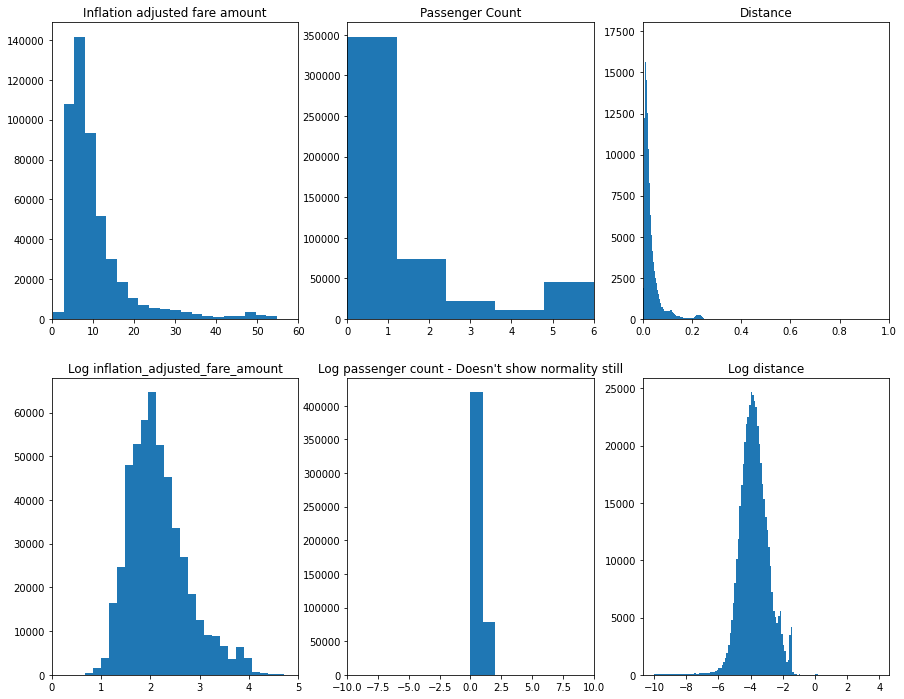

In [12]:
eps = 1e-50
fig2 = plt.figure(figsize = [15,12])
grid_spec_2 = gd.GridSpec(nrows = 2,ncols = 3)
fig2_1 = fig2.add_subplot(grid_spec_2[0,0]) 
fig2_2 = fig2.add_subplot(grid_spec_2[0,1])
fig2_3 = fig2.add_subplot(grid_spec_2[1,0])
fig2_4 = fig2.add_subplot(grid_spec_2[1,1])
fig2_5 = fig2.add_subplot(grid_spec_2[0,2])
fig2_6 = fig2.add_subplot(grid_spec_2[1,2])

fig2_1.hist(Data_test_3['inflation_adjusted_fare_amount'],bins = 200)
fig2_1.set_title("Inflation adjusted fare amount")
fig2_1.set_xlim(0,60)
fig2_2.hist(Data_test_3['passenger_count'],bins = 5)
fig2_2.set_xlim(0,6)
fig2_5.hist(Data_test_3['distance'],bins = np.arange(0,0.4,step = 0.001))
fig2_5.set_title("Distance")
fig2_5.set_xlim(0,1)
fig2_2.set_title("Passenger Count")
fig2_3.hist(np.log(Data_test_3['inflation_adjusted_fare_amount']+eps),bins = 750)
fig2_3.set_title("Log inflation_adjusted_fare_amount")
fig2_3.set_xlim(0,5)
fig2_4.hist(np.log(Data_test_3['passenger_count']+eps),bins = np.arange(0,10,step = 1))
fig2_4.set_title("Log passenger count - Doesn't show normality still")
fig2_4.set_xlim(-10,10)
fig2_6.hist(np.log(Data_test_3['distance']+eps),bins = np.arange(-10,4,step = 0.1))
fig2_6.set_title("Log distance")

plt.plot()
plt.show()

### Scatter plot of Passenger count with fair amount

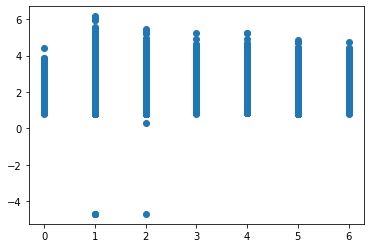

In [13]:
Data_test_3['log_inflation_fair_amount'] = np.log(Data_test_3['inflation_adjusted_fare_amount'])
fig3_1 = plt.scatter(Data_test_3['passenger_count'],np.log(Data_test_3['inflation_adjusted_fare_amount'])) 
plt.plot()
plt.show()

### From the graph above and the results below , we can observe that the passenger count doesn't have an impact on fare amount, Hence we will move on to Plots of distance with fare amount

In [14]:
Data_test_3.loc[:,['passenger_count','inflation_adjusted_fare_amount']].groupby('passenger_count').agg([len,np.min,np.median,np.mean,np.max])

inflation_adjusted_fare_amount                       \
                                           len       amin    median   
passenger_count                                                       
0                                       1791.0   2.262292  6.948303   
1                                     346009.0 -43.953260  7.803421   
2                                      73908.0  -2.262292  8.144249   
3                                      21761.0 -17.718352  8.090490   
4                                      10614.0  -2.754149  8.262446   
5                                      35322.0  -2.714750  7.929207   
6                                      10590.0  -4.524583  8.262446   

                                        
                      mean        amax  
passenger_count                         
0                 8.474857   80.763807  
1                10.566293  475.911198  
2                11.166980  238.518361  
3                10.817552  188.222653  
4                11.102861  194.112393  
5                10.613925  128.045485  
6                11.356044  113.709608

### Density Plot of Fare amount with Distance 

#### As we observe from the graph below we see that there is some sort of relation between the fare amount and distance ( As the distance increases the fare amount also increases)

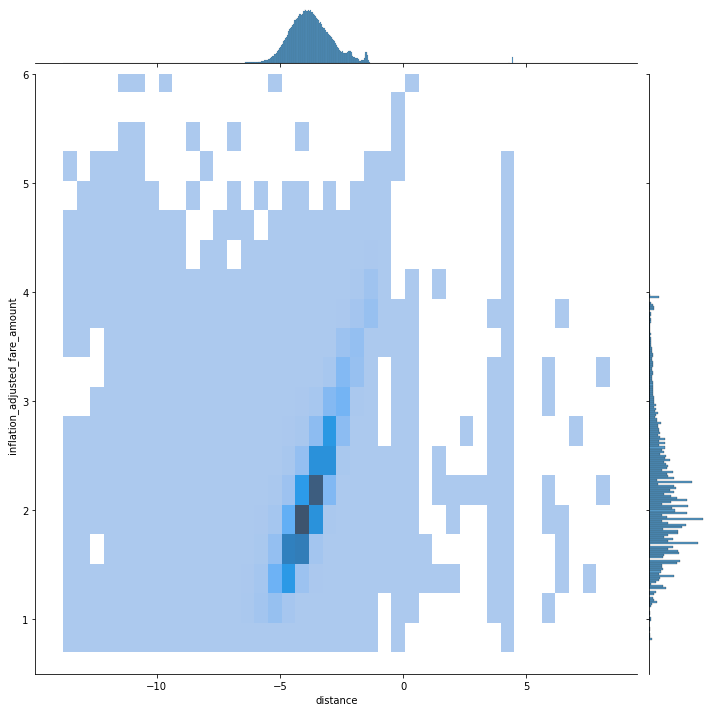

In [15]:
something = sns.jointplot(np.log(Data_test_3['distance']),np.log(Data_test_3['inflation_adjusted_fare_amount']),kind = "hist",ratio = 9,ylim = [0.5,6],joint_kws=dict(bins = 40),height=10)
plt.plot()
plt.show()

## Bar plots for Trip count by Year - Month

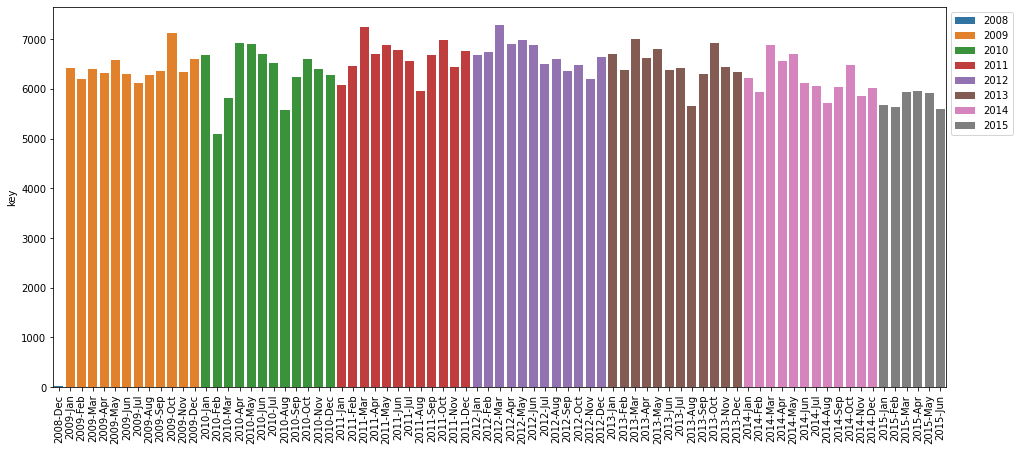

In [16]:

Data_4 = pd.DataFrame(Data_test_3['key'].groupby(by = [Data_test_3['pickup_datetime_2'].dt.year,Data_test_3['pickup_datetime_2'].dt.month]).agg(len))
Data_4_year = pd.Series(Data_4.droplevel(level = 1).index).apply(str)
Month = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
Year_month= pd.Series([str(i)+"-"+ Month[j] for i in range(2008,2016) for j in Month.keys()])
Year_Month_2 = Year_month.drop(index = [0,1,2,3,4,5,6,7,8,9,10,95,94,93,92,91,90])
Year_Month_2.index = range(0,79)
Data_4.index = Year_Month_2
Data_4_year.index = Year_Month_2
Data_4['Year'] =  Data_4_year
fig_barplot_year_month = plt.figure(figsize = [16,7])
ax_1 = fig_barplot_year_month.subplots()
ax_1 = sns.barplot(x = Data_4.index, y = Data_4['key'],hue = Data_4['Year'],dodge = False)
ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation = 90)
ax_1.legend(loc = 'upper left',bbox_to_anchor = (1,1))
plt.show()


We see above that the trip count follows a cyclical pattern wherein the trip count increases around April, reduces in August and then subsequently increases during the winter season. Another macro pattern we observe is that the trip count has been decreasing steadily as the months pass.

## Bar plot of Trip counts by Month, Weekday, Weekday-Year & Quarter  

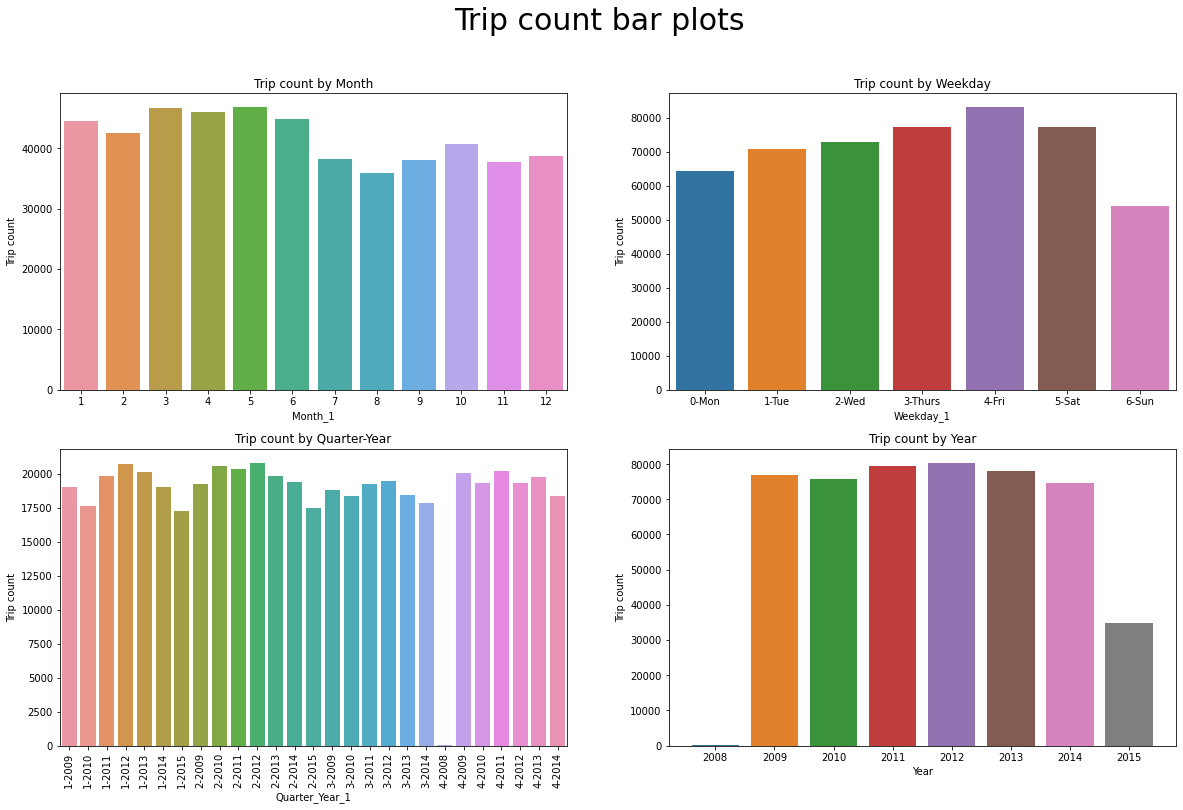

In [17]:
Data_test_3['Month_1'] = Data_test_3['pickup_datetime_2'].dt.month
Weekday_day = {0:"Mon",1:"Tue",2:"Wed",3:"Thurs",4:"Fri",5:"Sat",6:"Sun"}
Data_test_3['Weekday_1'] = Data_test_3['pickup_datetime_2'].dt.weekday.apply(lambda x: str(x)+"-"+str(Weekday_day[x]))
Data_test_3['Quarter_Year_1'] = Data_test_3['pickup_datetime_2'].dt.quarter.map(str) + "-" + Data_test_3['Year'].map(str)
Data_test_3['Weekday_Year_1'] = Data_test_3['Weekday_1'].map(str) + "-" + Data_test_3['Year'].map(str)

columns = ['Month_1','Weekday_1','Quarter_Year_1','Year']
barplot_fig_1, ((Month_1,Weekday_1),(Quarter_Year_1,Year)) = plt.subplots(figsize = (20,12),nrows = 2,ncols = 2)
for i in columns:
    sns.barplot(ax = vars()[i],x = Data_test_3[i].groupby(by = Data_test_3[i]).agg(len).index ,y= Data_test_3[i].groupby(by = Data_test_3[i]).agg(len),dodge = False)
    vars()[i].set_ylabel("Trip count")
Quarter_Year_1.set_xticklabels(Quarter_Year_1.get_xticklabels(),rotation = 90)
Weekday_1.set_title("Trip count by Weekday")
Month_1.set_title("Trip count by Month")
Quarter_Year_1.set_title("Trip count by Quarter-Year")
Year.set_title("Trip count by Year")
barplot_fig_1.suptitle("Trip count bar plots", fontsize = 30)
plt.plot()
plt.show()


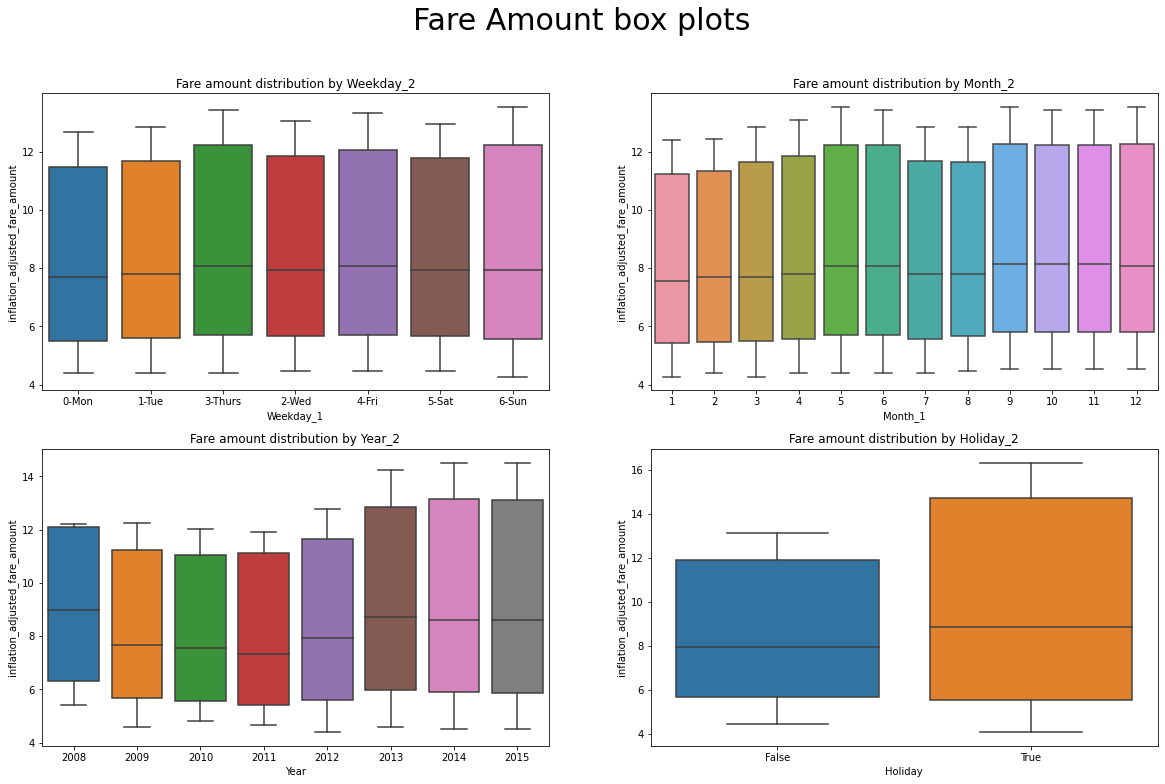

In [18]:
cal = calendar()
holidays = cal.holidays(start=Data_test_3['pickup_datetime_2'].dt.date.min(), end=Data_test_3['pickup_datetime_2'].dt.date.max())
Data_test_3['Holiday'] = Data_test_3['pickup_datetime_2'].dt.date.isin(holidays)

axes_1 = ['Weekday_2', 'Month_2','Year_2','Holiday_2']
barplot_fig_2, ((Weekday_2,Month_2),(Year_2,Holiday_2)) = plt.subplots(figsize = (20,12),nrows = 2,ncols = 2)
sns.boxplot(ax = Weekday_2, x = 'Weekday_1',y= 'inflation_adjusted_fare_amount',data = Data_test_3,showfliers = False,whis = 0.2)
sns.boxplot(ax = Month_2, x = 'Month_1',y= 'inflation_adjusted_fare_amount',data = Data_test_3,showfliers = False,whis = 0.2)
sns.boxplot(ax = Year_2, x = 'Year',y= 'inflation_adjusted_fare_amount',data = Data_test_3,showfliers = False,whis = 0.2)
sns.boxplot(ax = Holiday_2, x = 'Holiday',y= 'inflation_adjusted_fare_amount',data = Data_test_3,showfliers = False,whis = 0.2)
barplot_fig_2.suptitle("Fare Amount box plots", fontsize = 30)

for i in axes_1:
    vars()[i].set_title(str("Fare amount distribution by "+i))

plt.plot()
plt.show()

## Fare Amount, Trip distance, Trip count by hour

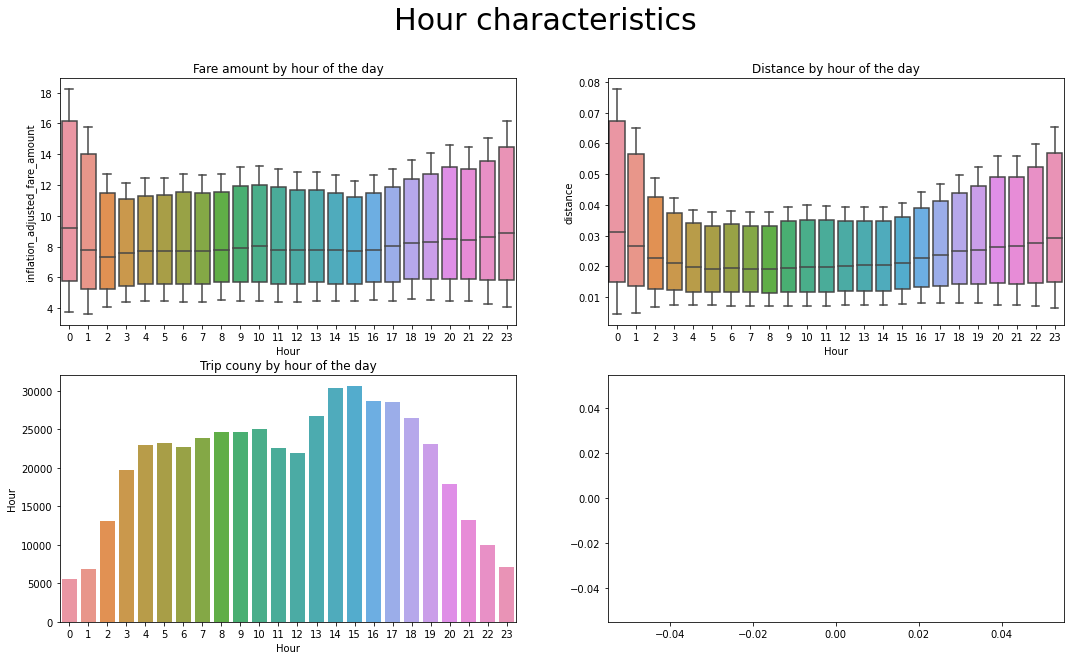

In [19]:
Data_test_3['Hour'] = Data_test_3['pickup_datetime_2'].dt.hour

hourplots, hourplot_ax = plt.subplots(figsize = (18,10), ncols = 2, nrows = 2)
sns.boxplot(ax = hourplot_ax[0,0], x = Data_test_3['Hour'], y = Data_test_3['inflation_adjusted_fare_amount'],showfliers = False,whis = 0.2)
sns.boxplot(ax = hourplot_ax[0,1], x = Data_test_3['Hour'], y = Data_test_3['distance'], showfliers = False, whis=0.2)
sns.barplot(ax = hourplot_ax[1,0], x = Data_test_3['Hour'].groupby(by = Data_test_3['Hour']).agg(len).index, y = Data_test_3['Hour'].groupby(by = Data_test_3['Hour']).agg(len))
hourplot_ax[0,0].set_title("Fare amount by hour of the day")
hourplot_ax[0,1].set_title("Distance by hour of the day")
hourplot_ax[1,0].set_title("Trip couny by hour of the day")
hourplots.suptitle("Hour characteristics", fontsize = 30)
plt.plot()
plt.show()

In [20]:
! pip install "C:\Users\harsh\OneDrive\Documents\Kaggle\Google Taxi Fare forecasting\Google-NY-Taxi-Fare\GDAL-3.3.3-cp37-cp37m-win_amd64.whl"

Processing c:\users\harsh\onedrive\documents\kaggle\google taxi fare forecasting\google-ny-taxi-fare\gdal-3.3.3-cp37-cp37m-win_amd64.whl
GDAL is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [21]:
!! pip install "C:\Users\harsh\OneDrive\Documents\Kaggle\Google Taxi Fare forecasting\Google-NY-Taxi-Fare\Fiona-1.8.20-cp37-cp37m-win_amd64.whl"

['Processing c:\\users\\harsh\\onedrive\\documents\\kaggle\\google taxi fare forecasting\\google-ny-taxi-fare\\fiona-1.8.20-cp37-cp37m-win_amd64.whl',
 'Requirement already satisfied: click>=4.0 in c:\\users\\harsh\\appdata\\local\\programs\\python\\python37\\lib\\site-packages (from Fiona==1.8.20) (8.0.3)',
 'Requirement already satisfied: certifi in c:\\users\\harsh\\appdata\\local\\programs\\python\\python37\\lib\\site-packages (from Fiona==1.8.20) (2021.10.8)',
 'Requirement already satisfied: munch in c:\\users\\harsh\\appdata\\local\\programs\\python\\python37\\lib\\site-packages (from Fiona==1.8.20) (2.5.0)',
 'Requirement already satisfied: gdal~=3.3.0 in c:\\users\\harsh\\appdata\\local\\programs\\python\\python37\\lib\\site-packages (from Fiona==1.8.20) (3.3.3)',
 'Requirement already satisfied: setuptools in c:\\users\\harsh\\appdata\\local\\programs\\python\\python37\\lib\\site-packages (from Fiona==1.8.20) (39.0.1)',
 'Requirement already satisfied: six>=1.7 in c:\\users\\

In [22]:
!pip install geopandas

In [23]:
import geopandas as gpd

In [47]:
New_york = gpd.read_file(r"C:\Users\harsh\OneDrive\Documents\Kaggle\Google Taxi Fare forecasting\Google-NY-Taxi-Fare\Shapefiles and base map\geo_export_ddcd476f-2bfb-4e2f-9a67-6dbb83336f14.shp")

In [ ]:
New_york_2 = New_york.to_crs("EPSG:4326")
Ny_fig, ny_ax = plt.subplots(figsize = (12,12))
New_york_2.plot(ax = ny_ax, color = "white", edgecolor = "black")
ny_ax.scatter(x = Data_test_3['pickup_latitude'], y = Data_test_3['pickup_longitude'],alpha=0.6,s = 3)
ny_ax.set_xlim(-74.06,-73.97)
ny_ax.set_ylim(40.7,40.9)
plt.plot()
plt.show()

In [43]:
!pip install folium

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for folium: filename=folium-0.12.1.post1-py2.py3-none-any.whl size=95017 sha256=c111eb13191079b8e5ad4b87627194f2b0f5d6e6239359f9e5dc0fe1598feae8
  Stored in directory: c:\users\harsh\appdata\local\pip\cache\wheels\cf\d2\b1\569dd3ad4959f691dbd11987ac20ee2d5d58cb7d9f45968cae
Successfully built folium
